In [1]:
import cv2, imutils, os, csv, mahotas
from glob import glob
import numpy as np
import pandas as pd
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
import random
import joblib
from scipy import stats
import skimage.feature.texture as sft
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.decomposition import PCA
from ReliefF import ReliefF
from sklearn.feature_selection import SelectKBest, f_classif

from tqdm import tqdm


In [2]:
class Feature:
    def __init__(self):
        self.scaler = StandardScaler()
        self.mscaler = MinMaxScaler(feature_range=(0, 1))
        self.pca = PCA(n_components=40)
        self.relief = ReliefF(n_features_to_keep=30)
        self.bestK = SelectKBest(f_classif, k=30)

    def extract_global_features(self, img):
        global_features = []
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
        feature = [np.mean(R), np.std(R), np.mean(G), np.std(G), np.mean(B), np.std(B)]
        global_features.extend(feature/np.mean(feature))

        hist = cv2.calcHist([img_hsv], [0, 1, 2], None, (8, 2, 2), [0, 256, 0, 256, 0, 256])
        cv2.normalize(hist, hist)
        global_features.extend(hist.flatten())      

        glcm = sft.greycomatrix(img_gray, distances = [1], angles = [0], symmetric=True, normed=True)
        # glcm = sft.greycomatrix(img_gray, distances = [1], angles = [0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
        props = ['contrast', 'correlation', 'energy', 'homogeneity']
        feature = [sft.greycoprops(glcm, prop).ravel()[0] for prop in props]
        feature = feature / np.sum(feature)
        global_features.extend(feature)

        # feature = mahotas.features.haralick(img_gray).ravel()
        # global_features.extend(feature)
        
        feature = cv2.HuMoments(cv2.moments(img_gray)).flatten()
        global_features.extend(feature)

        # global_features = stats.zscore(np.array(global_features))

        return global_features

    def normalization_train(self, data_train, target):
        
        data_train = self.pca.fit_transform(data_train)
        # data_train = self.mscaler.fit_transform(data_train)
        data_train = self.scaler.fit_transform(data_train)

        dic = { val : nb for nb, val in enumerate(set(target))}
        target2nb = [dic[l] for l in target]
        data_train = np.array(data_train)
        target2nb = np.array(target2nb)
        # data_train = self.bestK.fit_transform(data_train, target2nb)
        data_train = self.relief.fit_transform(data_train, target2nb)
        return data_train

    def normalization_test(self, data_test):
        
        data_test = self.pca.transform(data_test)
        # data_test = self.mscaler.transform(data_test)
        data_test = self.scaler.transform(data_test)
        data_test = np.array(data_test)
        # data_test = self.bestK.transform(data_test)
        data_test = self.relief.transform(data_test)
        return data_test

Ft = Feature()


In [3]:
#Helper function to load images from given directories    
def indexing_images(directorys, csv_path):
    df = pd.read_csv(csv_path)
    print("\nLoad images and Indexing : ")
    all_files = glob(str(directorys)+os.path.sep+"*.*")
    features = []
    labels = []

    for imagePath in tqdm(all_files):       
        feature = Ft.extract_global_features(cv2.imread(imagePath))
        features.append(feature)
        imgName = imagePath.split(os.path.sep)[-1].split(".")[0]
        # print(imgName)
        label = np.array(df[df['image_id']==imgName]['melanoma'])[0]
        labels.append(label)

    return np.array(features), np.array(labels)

In [4]:
def Apprentissage(modelName, data_train, target_train):
    print("\n\n** Read data : ")
    features, labels = indexing_images(data_train, target_train)

    print("\n\n** Normalization : ")
    features = Ft.normalization_train(features, labels)
    
    print("\n\n** Apprentissage : ")    
    # train and evaluate a k-NN classifer on the raw pixel intensities
    # model = KNeighborsClassifier(n_neighbors=16)

    # model = svm.SVC(gamma=0.01, C=100, kernel='linear')
    # model = svm.SVC(kernel='rbf')
    model = svm.SVC(kernel='linear')
    print("[INFO] evaluating raw pixel accuracy...")

    model.fit(features,labels)
    # save the model to disk
    joblib.dump(model, modelName)
    print("[DONE]")


In [5]:
def Classification(model_path , directorys, csv_path):
    features, labels = indexing_images(directorys, csv_path)
    features = Ft.normalization_test(features)
    loaded_model = joblib.load(model_path)
    print("\n\nTaux de précision :", loaded_model.score(features, labels)*100 , "%")

In [6]:
def Classification_2_csv(model_path , dir1, csv_path):
    loaded_model = joblib.load(model_path)

    features = []
    imgIds = []
    for img_path in glob(dir1+os.path.sep+"*.*"):
        features.append(Ft.extract_global_features(cv2.imread(img_path)))
        imgIds.append(img_path.split(os.path.sep)[-1].split(".")[0])
    
    features = Ft.normalization_test(features)
    melanoma = [loaded_model.predict([feature])[0] for feature in features]
    df = pd.DataFrame({'image_id': imgIds, 'melanoma': melanoma})
    df.to_csv(csv_path, index=False)

In [7]:
def bestK_KNN(X_train, y_train, X_test, y_test):
    Ks = 200
    mean_acc = np.zeros((Ks-1))
    for n in tqdm(range(1,Ks)):
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
        mean_acc[n-1] = neigh.score(X_test, y_test)

    import matplotlib.pyplot as plt
    plt.plot(range(1,Ks),mean_acc,'g')
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Number of Nabors (K)')
    plt.tight_layout()
    plt.show()
    print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 
    return mean_acc.argmax()+1 , mean_acc.max()

In [8]:
def best_SVM(X_train, y_train, X_test, y_test):
    # from sklearn import metrics
    C = 200
    mean_acc = np.zeros((C-1))
    for n in tqdm(range(1, C)):
        # model = svm.SVC(gamma=0.01, C=100, kernel='linear').fit(X_train,y_train)
        model = svm.SVC(gamma=0.01, C=C, kernel='rbf').fit(X_train,y_train)
        mean_acc[n-1] = model.score(X_test, y_test)
        break
    import matplotlib.pyplot as plt
    plt.plot(range(1,C),mean_acc,'g')
    plt.legend(('Accuracy ', '+/- 3xstd'))
    plt.ylabel('Accuracy ')
    plt.xlabel('Number of Nabors (K)')
    plt.tight_layout()
    plt.show()
    print( "The best accuracy was with : ", mean_acc.max(), "with C = ", mean_acc.argmax()+1) 
    return mean_acc.argmax()+1 , mean_acc.max()

In [9]:
home = "D:/WISD/S3/Image_Mining/Atelier_6/"

data_train      = home + "Classification DataSet/ISIC-2017_Training_Data"
data_train_mask = home + "Classification DataSet/ISIC-2017_Training_Part1_GroundTruth"
data_valid      = home + "Classification DataSet/ISIC-2017_Validation_Data"
data_valid_mask = home + "Classification DataSet/ISIC-2017_Validation_Data"
data_test       = home + "Classification DataSet/ISIC-2017_Test_v2_Data"

target_train    = home + "ISIC-2017_Training_Part3_GroundTruth.csv"
target_valid    = home + "ISIC-2017_Validation_Part3_GroundTruth.csv"

model      = home + 'finalized_model.sav'
csv_file   = home + "index.csv"

In [10]:
f_train, l_train = indexing_images(data_train, target_train)
f_valid, l_valid = indexing_images(data_valid, target_valid)

0%|          | 0/2000 [00:00<?, ?it/s]
Load images and Indexing : 
  4%|▍         | 6/150 [00:00<00:02, 53.09it/s]
Load images and Indexing : 
100%|██████████| 150/150 [00:03<00:00, 43.69it/s]


In [11]:

X_train = Ft.normalization_train(f_train, l_train)
X_valid = Ft.normalization_test(f_valid)



In [12]:
accuracy, C = best_SVM(X_train, l_train, X_valid, l_valid )

100%|██████████| 199/199 [03:03<00:00,  1.08it/s]


RuntimeError: In FT2Font: Can not load face.

100%|██████████| 199/199 [00:09<00:00, 21.55it/s]
The best accuracy was with0.8066666666666666with k=8


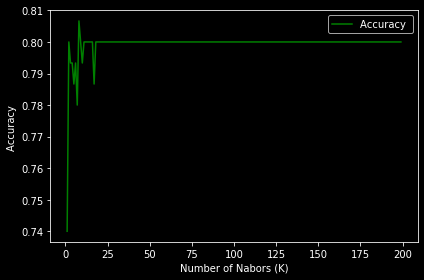

In [19]:
accuracy, k = bestK_KNN(X_train, l_train, X_valid, l_valid )

In [12]:
data = np.concatenate([f_train, f_valid])
target = np.concatenate([l_train, l_valid]).flatten()
data = Ft.normalization_train(data, target)
data.shape


(2150, 30)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import KFold

clf = svm.SVC(gamma=0.01, C=1, kernel='rbf')

In [14]:

scores = cross_val_score(clf, data, target, cv=5)
scores

array([0.81206497, 0.81162791, 0.81162791, 0.81162791, 0.81351981])

In [15]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, data, target, cv=cv)

array([0.84031008, 0.81550388, 0.81395349, 0.80620155, 0.83255814])

In [27]:

scores = []
indexes = []
cv = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in cv.split(data):
    # print("Train Index: ", train_index, "\n")
    # print("Test Index: ", test_index)
    indexes.append((train_index, test_index))
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], target[train_index], target[test_index]
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))
print("accuracy = ",scores)

accuracy =[0.7627906976744186, 0.7534883720930232, 0.8511627906976744, 0.813953488372093, 0.8372093023255814, 0.9348837209302325, 0.9348837209302325, 0.6837209302325581, 0.7906976744186046, 0.7581395348837209]


In [31]:
# scores_ = []
good_index = []
bad_index = []
pbar = tqdm(total=len(target))
cv = KFold(n_splits=len(target), random_state=42, shuffle=False)
for train_index, test_index in cv.split(data):
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], target[train_index], target[test_index]
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    # scores_.append(score)
    if score == 1:
        good_index.append(test_index[0])
    else:
        bad_index.append(test_index[0])
    pbar.update(1)
pbar.close()

good_data, bad_data, good_target, bad_target = data[good_index], data[bad_index], target[good_index], target[bad_index]
print(good_data.shape, good_target.shape)
print(bad_data.shape, bad_target.shape)
scores

100%|██████████| 2150/2150 [12:38<00:00,  2.83it/s]
(1745, 30)(1745,)
(405, 30)(405,)


[1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [41]:
scores = []
indexes = []
cv = KFold(n_splits=4, random_state=42, shuffle=True)
for train_id, test_id in cv.split(good_data):
    indexes.append((train_id, test_id))
    X_train, X_test, y_train, y_test = good_data[train_id], good_data[test_id], good_target[train_id], good_target[test_id]

    data2 = np.concatenate([X_train, bad_data])
    target2 = np.concatenate([y_train, bad_target]).flatten()

    clf.fit(data2, target2)
    scores.append(clf.score(X_test, y_test))
print("\nAccuracy : ", scores)
print("\nMean accuracy = ", np.mean(scores))


Accuracy :[1.0, 0.9977064220183486, 1.0, 1.0]

Mean accuracy =0.9994266055045872


In [38]:
scores = []
cv = KFold(n_splits=4, random_state=42, shuffle=True)
for train_id, test_id in cv.split(good_target):
    X_train, X_test, y_train, y_test = good_data[train_id], good_data[test_id], good_target[train_id], good_target[test_id]

    for train_id, test_id in cv.split(bad_target):
        X1_train, X1_test, y1_train, y1_test = bad_data[train_id], bad_data[test_id], bad_target[train_id], bad_target[test_id]

        data_train = np.concatenate([X_train, X1_train])
        data_test = np.concatenate([X_train, X1_train])
        target_train = np.concatenate([y_train, y1_train]).flatten()
        target_test = np.concatenate([y_train, y1_train]).flatten()

        clf.fit(data_train, target_train)
        scores.append(clf.score(data_test, target_test))
print("\nAccuracy : ", scores)
print("\nMean accuracy = ", np.mean(scores))


Accuracy :[0.8162631905648665, 0.8194789081885856, 0.8182382133995038, 0.8188585607940446, 0.8182382133995038, 0.8214507129572226, 0.8189708617482951, 0.8202107873527589, 0.8163771712158809, 0.8202107873527589, 0.8189708617482951, 0.8189708617482951, 0.8176178660049628, 0.8220706757594545, 0.8189708617482951, 0.8202107873527589]

Mean accuracy =0.8190693325834677


<h1> Pandas </h1>


In [48]:
f_train, l_train = indexing_images(data_train, target_train)
f_valid, l_valid = indexing_images(data_valid, target_valid)


Load images and Indexing :
100%|██████████| 2000/2000 [00:38<00:00, 51.78it/s]

Load images and Indexing :
100%|██████████| 150/150 [00:02<00:00, 53.45it/s]


In [27]:
df = pd.DataFrame(f_train)
df2 = pd.DataFrame(f_valid)
df = df.append(df2, ignore_index=True)
df['target'] = np.concatenate([l_train, l_valid]).flatten()
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,target
0,1.556945,0.788326,1.354498,0.647023,1.204237,0.448972,0.125467,0.002398,0.000000,0.000000,...,0.004173,0.034408,0.001418,1.547450e-09,1.340238e-12,3.235321e-12,6.703884e-24,1.272397e-16,6.672229e-25,0.0
1,1.690032,0.368528,1.653961,0.324220,1.695563,0.267697,0.063987,0.133090,0.049159,0.000000,...,0.008464,0.046454,0.001077,2.234248e-11,9.569708e-14,2.666654e-13,1.532342e-26,-1.257217e-18,3.974754e-26,0.0
2,1.831988,0.643233,1.473167,0.438571,1.329030,0.284011,0.144798,0.067485,0.005529,0.000000,...,0.001060,0.009341,0.001131,7.551190e-10,3.247001e-12,9.564055e-13,-1.430332e-24,9.101967e-18,-8.914817e-25,1.0
3,1.414599,0.609486,1.484120,0.514173,1.602145,0.375477,0.076920,0.714768,0.195031,0.184670,...,0.004911,0.031861,0.001066,7.262101e-10,2.593579e-14,2.465819e-12,-6.152736e-25,-2.156691e-17,1.014353e-25,0.0
4,0.963570,1.050562,0.824407,0.916265,1.090085,1.155111,0.874387,0.000289,0.016100,0.000029,...,0.003169,0.006669,0.001089,6.826491e-08,2.133147e-12,3.602963e-12,-6.894211e-24,-8.606242e-16,7.227720e-24,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,1.382042,0.507634,1.535548,0.396470,1.933114,0.245193,0.002782,0.981445,0.092987,0.166291,...,0.000734,0.006923,0.001322,2.136077e-09,7.951646e-13,2.758442e-13,9.492764e-26,5.553552e-18,-8.762675e-26,0.0
2146,1.199340,0.413577,1.327032,0.444502,2.082198,0.533351,0.017702,0.989701,0.136898,0.036501,...,0.001602,0.017141,0.001172,1.908354e-08,9.135694e-12,1.730780e-12,5.753813e-24,3.886426e-17,-3.776202e-24,0.0
2147,1.365319,0.427694,1.512880,0.431110,1.839935,0.423064,0.106340,0.993425,0.040323,0.004362,...,0.000114,0.001100,0.001124,5.008973e-11,5.404823e-13,5.917619e-13,8.626038e-26,3.952472e-18,3.233578e-25,0.0
2148,1.357677,0.550792,1.436802,0.510641,1.741232,0.402855,0.000000,0.964128,0.125666,0.190298,...,0.001155,0.009641,0.000961,1.217275e-10,3.069750e-13,2.215950e-12,1.720743e-24,1.724621e-17,-6.158904e-25,0.0


In [39]:
df['target'].value_counts()


0.0    1746
1.0     404
Name: target, dtype: int64

In [47]:
df2 = pd.DataFrame(Ft.normalization_train(df.drop(['target'], axis=1), df['target']))
df2

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.910516,-1.207967,-0.079114,-1.850326,4.997886,4.410619,-1.452501,3.501283,3.280592,-0.185246,...,-1.825058,3.202319,0.919542,6.481231,0.171307,1.166572,-0.621097,-0.663362,1.797113,-0.038335
1,-0.794759,0.047584,-0.164884,-2.765535,-1.290899,-0.066750,-0.918277,-0.663682,-1.601512,-1.243908,...,-0.633148,0.311661,0.193598,8.845380,-0.280329,-0.449778,0.278109,0.400028,0.093941,-0.784695
2,0.639598,-2.912820,-0.257360,-2.103222,1.038697,-2.310250,-0.556639,0.361640,2.036633,0.598001,...,-0.314919,-0.567046,0.271743,-4.435540,1.489747,-0.337305,0.132409,-1.079871,0.349506,-3.326138
3,-0.016035,1.213222,0.491392,-1.234313,-0.141730,0.228317,1.249583,-1.886256,-2.465340,-0.354045,...,-0.379900,1.304599,0.543330,2.581756,-0.029602,-0.328402,-0.701185,-0.345797,-1.313922,-0.559660
4,0.283391,0.643598,-1.522285,0.751985,-1.796752,-4.637233,0.109715,2.899278,1.878886,-2.710457,...,-2.090547,4.189405,1.247005,-0.917534,-0.282212,1.163282,2.603531,-0.425246,-0.051125,12.938859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2145,-0.045117,0.443091,-0.012795,0.399091,1.021986,-0.910801,0.094090,0.396934,0.425754,1.004275,...,-0.139882,-0.086733,-0.353068,-0.323300,0.107014,-0.137324,-0.411283,0.226377,1.373274,-0.009100
2146,-0.040006,-1.040905,-0.603053,-0.179807,-0.326505,-0.520492,0.576130,0.096945,1.375341,-0.586451,...,-1.242594,-0.046603,-0.997641,-0.553279,-0.041186,-1.694942,-0.522261,2.777147,-1.133133,-0.265988
2147,-0.030699,-0.666575,-0.289627,-0.492487,-0.896870,-0.443159,-0.297705,0.805472,0.182313,0.038800,...,-0.662224,0.157102,-0.455225,1.020742,-0.078998,-0.192396,0.229737,-0.797272,0.318913,-0.408701
2148,-0.070852,0.212480,0.015760,-0.087268,-0.473921,0.018013,0.025836,-0.271654,0.592863,0.875602,...,-0.621496,0.078398,0.740173,0.790870,-0.104720,-0.183558,-0.325033,-0.646551,-0.959591,-0.349852


In [ ]:
df2 = pd.DataFrame(Ft.normalization_train(df.drop(['target'], axis=1), df['target']))
df2